# Stoneburner, Kurt
- ## DSC 650 - Assignment 12


Importing Pillow images into Numpy
https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

Pillow Resize Images: https://pythonexamples.org/python-pillow-resize-image/

Celeb A Dataset: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [1]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#//*** Use the whole window in the IPYNB editor
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#//*** Clear the output display, helpful for content that updates
from IPython.display import clear_output


#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

import PIL
from PIL import Image
#//*** Get Working Directory
current_dir = Path(os.getcwd()).absolute()

#//*** Build Image Directory
base_image_dir = current_dir.parents[2].joinpath("img_align_celeba")

resize_dir = base_image_dir.joinpath("resize_128")

Tensorflow Datasets: https://www.tensorflow.org/datasets/overview

Processing:  50000 / 50000


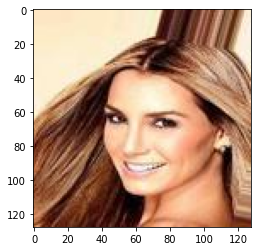

(128, 128, 3)
25000
25000 25000


In [2]:
attribs = {
    'size' : (128,128),
    'keras_dims' : (128,128,3),

    'sample_size' : 50000,
    'test_split' : .5
}

x_train = []




counter = 1
for filename in os.listdir(base_image_dir)[:attribs['sample_size']]:
    clear_output(wait=True)
    
    
    #//*** Check if File has already been resized
    if os.path.exists(resize_dir.joinpath(filename)) == False:
        print("Resizing: ", counter,"/",attribs['sample_size'])

        #//*** File does not exist. Open original and resize
    
        #//*** Open Pillow Image Object
        image = Image.open(base_image_dir.joinpath(filename))
    
        #//*** Resize Image
        image = image.resize(attribs['size'])
        
        #//*** Save Image
        image.save(resize_dir.joinpath(filename))
         
        #//*** Add image to training set
        x_train.append( np.asarray(image) )
    
    else:
        print("Processing: ", counter,"/",attribs['sample_size'])
        #//*** File Exists, Load it
        #//*** Open Pillow Image Object
        x_train.append(np.asarray(Image.open(resize_dir.joinpath(filename))))
        
    counter += 1

    
    #//*** Display Images
    #plt.imshow(image.resize(attribs['dims']))
    #plt.show()
    #print(type(data))
    #print(data.shape)

#//*** Display a sample image
plt.imshow(Image.fromarray(x_train[0])   )
plt.show()

print(x_train[0].shape)

#//*** Index to split for test train
split_index = len(x_train) - int(len(x_train)*attribs['test_split'])
print(split_index)

x_test = x_train[split_index:]

x_train = x_train[:split_index]

print(len(x_train),len(x_test))

**Variational Autoencoder network**

In [3]:
latent_dim = 3

encoder_inputs = keras.Input(shape=(attribs['keras_dims']))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 65536)        0           ['conv2d_1[0][0]']         

**Latent-Sapce-Sampling Layer**

In [4]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



**Variational decoder network, mapping latent space points to images**

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_1 (Dense)             (None, 65536)             262144    
                                                                 
 reshape (Reshape)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 3)       867 

**Variational Autoencoder with custom train_step()**

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

**Training the Variational Auto Encoder**

In [7]:
mnist_digits = np.concatenate([x_train, x_test], axis=0).astype("float32") / 255
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255



print(mnist_digits.shape)
#print(mnist_digits[0])

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

(50000, 128, 128, 3)
Epoch 1/30
391/391 [==============================] - 1077s 3s/step - total_loss: 10142.1309 - reconstruction_loss: 10131.2969 - kl_loss: 10.8362
Epoch 2/30
391/391 [==============================] - 1066s 3s/step - total_loss: 9896.7246 - reconstruction_loss: 9890.5732 - kl_loss: 6.1545
Epoch 3/30
391/391 [==============================] - 1062s 3s/step - total_loss: 9882.3047 - reconstruction_loss: 9877.4971 - kl_loss: 4.8009
Epoch 4/30
391/391 [==============================] - 1064s 3s/step - total_loss: 9876.1738 - reconstruction_loss: 9871.8262 - kl_loss: 4.3384
Epoch 5/30
391/391 [==============================] - 1063s 3s/step - total_loss: 9872.3643 - reconstruction_loss: 9868.1875 - kl_loss: 4.1765
Epoch 6/30
391/391 [==============================] - 1065s 3s/step - total_loss: 9877.9766 - reconstruction_loss: 9873.7109 - kl_loss: 4.2631
Epoch 7/30
391/391 [==============================] - 1063s 3s/step - total_loss: 9868.5176 - reconstruction_loss: 986

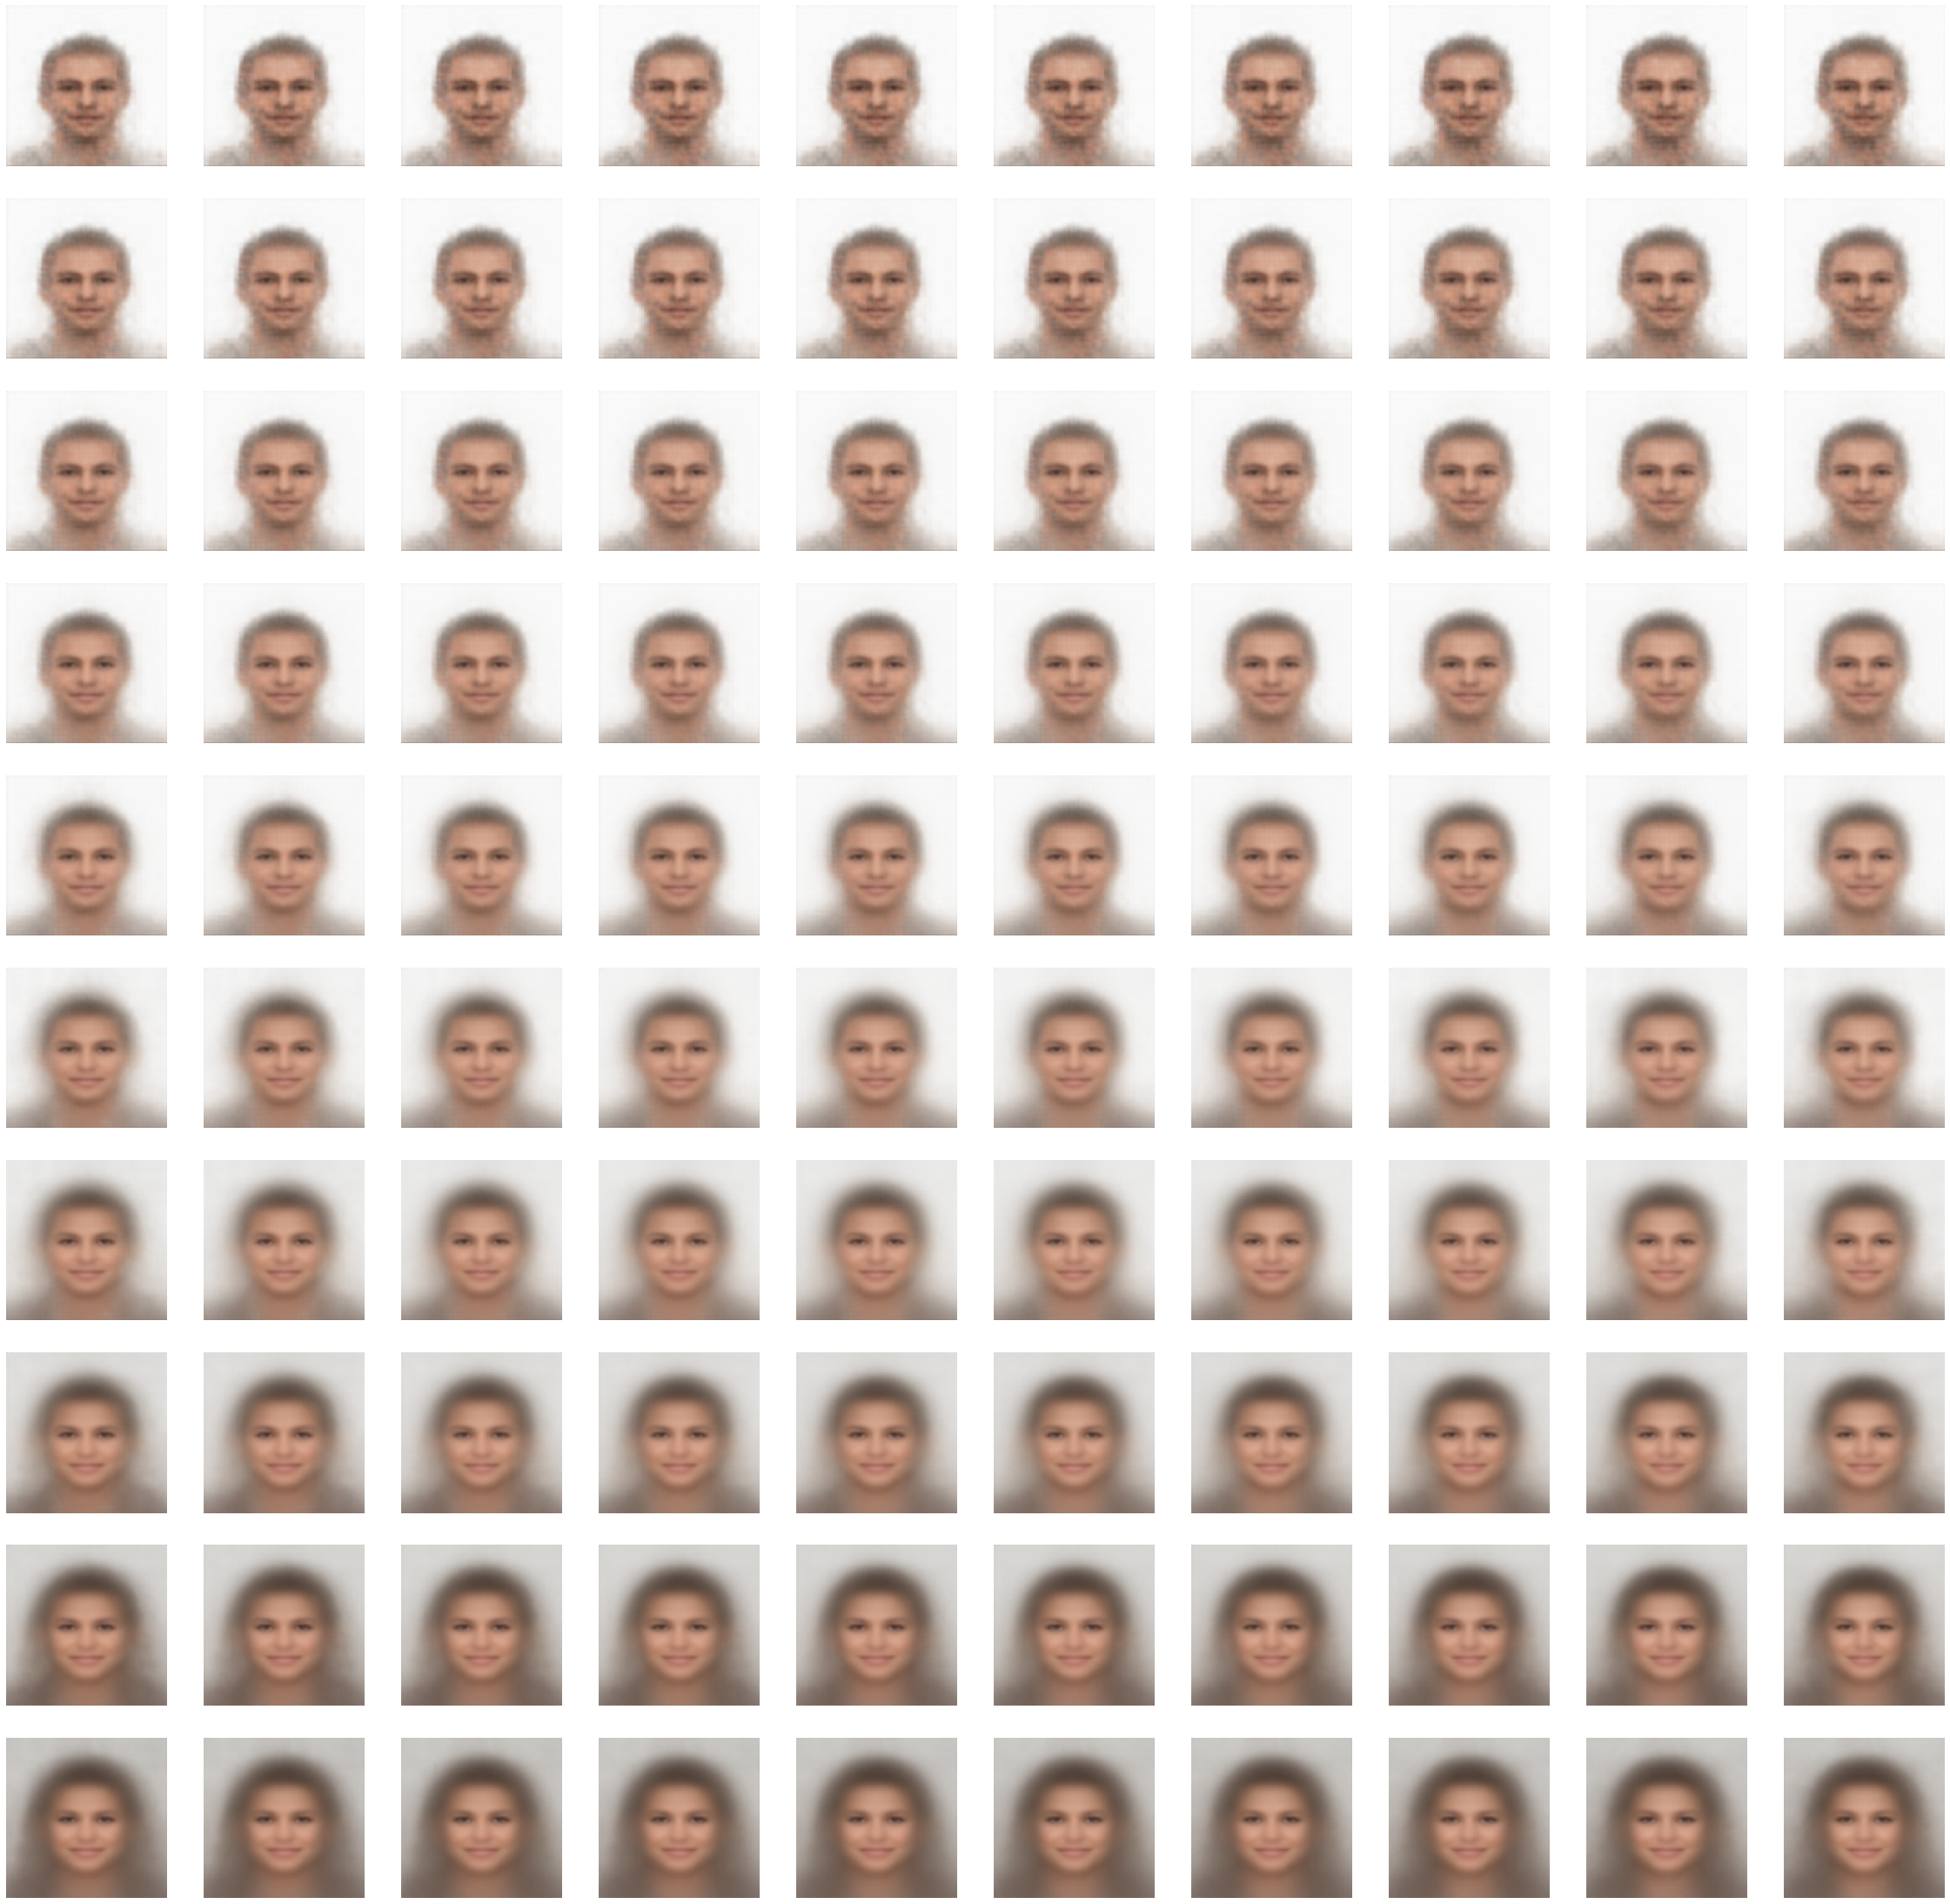

In [8]:
import matplotlib.pyplot as plt

n = 10
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]
plt.figure(figsize=(40,40))
count=1
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi,yi]])
        x_decoded = vae.decoder.predict(z_sample)[0]
        raw_img = (x_decoded*255).astype(np.uint8)
        plt.subplot(n,n,count)
        plt.imshow(Image.fromarray(raw_img)   )
        plt.axis("off")
        
        
        #raw_img = (x_decoded[0]*255).astype(np.uint8)
        #np.array(x_train).shape
        #type(raw_img)
        #type(x_train[0]),type(raw_img)
        #image2 = Image.fromarray(raw_img)
        #plt.subplot(5,i,j)
        #plt.imshow(Image.fromarray(raw_img)   )
        count+=1

plt.show()

**Sampling a grid of images from the 2D latent space**

In [9]:
# //*** CODE HERE